In [ ]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.2-py3-none-any.whl size=10650 sha256=4fc1c664903d5637d48c785a5ff79844eef60c077ca7987040f2ba240e6f7be5
  Stored in directory: /root/.cache/pip/wheels/b4/f6/8a/9daf8831901c3e3805775633404248f10663d1c80b7e5a1314
Successfully built minisom


# import


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.neighbors import KNeighborsClassifier
import pickle
# Evaluate performance
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

import time

# Methodologys
from sklearn import preprocessing

from tqdm import tqdm

from sklearn.metrics import roc_auc_score

from sklearn.metrics import matthews_corrcoef

from tabulate import tabulate

import random
from itertools import product


##urls

## normalize_with_tanh_estimator

In [ ]:
# Define the function for normalization using tanh-estimator method, excluding specified columns
def normalize_with_tanh_estimator(data, mean_std_dict):
    normalized_data = pd.DataFrame()
    for col in data.columns:
          mu, sigma = mean_std_dict[col]
          normalized_col = 0.5 * (np.tanh(0.1 * ((data[col] - mu) / sigma)) + 1)
          normalized_data[col] = normalized_col

    return normalized_data

## Distance calculation


In [ ]:
# Function to calculate distance between input sample V and reference point G
def calculate_distance(v, g, comments):
  """Calculates the distance between two points using different methods.

  Args:
    v: The first point.
    g: The second point.
    comment: A string indicating the desired distance method.

  Returns:
    The calculated distance.

  Raises:
    ValueError: If an unsupported distance method is specified.
  """

  if "euclidean" in comments:
    return np.linalg.norm(v - g)
  elif "manhattan" in comments:
    return np.sum(np.abs(v - g))
  elif "chebyshev" in comments:
    return np.max(np.abs(v - g))
  elif "cosine" in comments:
    # Ensure v and g are normalized for cosine distance
    v_norm = v / np.linalg.norm(v)
    g_norm = g / np.linalg.norm(g)
    return 1 - np.dot(v_norm, g_norm)
  else:
    raise ValueError(f"Unsupported distance method: {comments}")

## SOM_Prediction

In [ ]:
# Function to classify input sample as attack or normal and update y_pred array
def som_prediction_normal(sample, d_threshold, sigma, g):
  y_pred = []
  for sam in sample:
    distance_to_g = calculate_distance(sam, g)
    # print("distance_to_g", distance_to_g)
    p_d_greater_than_x = 1 - np.exp(- (distance_to_g / sigma)**2)  # Cumulative distribution function
    is_attack = distance_to_g > d_threshold or p_d_greater_than_x > 0.6  # You can adjust the threshold as needed
    y_pred.append(1 if is_attack else 0)

  return y_pred



# Function to classify input sample as attack or normal and update y_pred array

# def som_prediction(sample, d_threshold, g): # without sigma
#   y_pred = []
#   for sam in sample:
#     distance_to_g = calculate_distance(sam, g)
#     # print("distance_to_g", distance_to_g)
#     # p_d_greater_than_x = 1 - np.exp(- (distance_to_g / sigma)**2)  # Cumulative distribution function
#     is_attack = distance_to_g > d_threshold  # You can adjust the threshold as needed
#     y_pred.append(1 if is_attack else 0)

#   return y_pred


# Function to classify input sample as attack or normal and update y_pred array

def som_prediction(sample, d_threshold,sigma, g, comments): #with digma
  y_pred = []
  for sam in sample:
    distance_to_g = calculate_distance(sam, g, comments)
    # print("distance_to_g", distance_to_g)
    # p_d_greater_than_x = 1 - np.exp(- (distance_to_g / sigma)**2)  # Cumulative distribution function
    # print("distance to g and d_threshold", distance_to_g, d_threshold)
    is_attack = distance_to_g > d_threshold  # You can adjust the threshold as needed
    # print("is attack value", is_attack)
    y_pred.append(1 if is_attack else 0)

  return y_pred


## Genetic algorithm


In [48]:
def selection(population, fitness_scores):
  # # Roulette wheel selection
  # fitness_sum = sum(fitness_scores)
  # probabilities = [score / fitness_sum for score in fitness_scores]
  # parents = []
  # for _ in range(len(population)):
  #   parent = random.choices(population, weights=probabilities)[0]
  #   parents.append(parent)
  # return parents
  # # Assign ranks to individuals based on fitness scores
  #   ranked_population = sorted(population, key=lambda x: fitness_scores[population.index(x)], reverse=True)
  #   ranks = list(range(1, len(population) + 1))  # Assign ranks from 1 to N

  #   # Calculate selection probabilities based on ranks
  #   rank_sum = sum(ranks)
  #   probabilities = [rank / rank_sum for rank in ranks]

  #   # Select parents based on rank probabilities
  #   parents = []
  #   for _ in range(len(population)):
  #       parent = random.choices(ranked_population, weights=probabilities)[0]
  #       parents.append(parent)

  #   return parents
  tournament_size = 10  # Adjust the tournament size as needed
  selected_parents = []
  population_size = len(population)

  for _ in range(population_size):
        # Randomly select individuals for the tournament
        tournament = random.sample(list(zip(population, fitness_scores)), tournament_size)

        # Find the individual with the highest fitness in the tournament
        winner = max(tournament, key=lambda x: x[1])[0]

        # Add the winner to the selected parents
        selected_parents.append(winner)

  return selected_parents

def crossover(parents, crossover_rate):
  offspring = []
  for i in range(0, len(parents), 2):
    if random.random() < crossover_rate:
      parent1, parent2 = parents[i], parents[i+1]
      child1 = (parent1 + parent2) / 2
      child2 = (parent1 - parent2) / 2
      offspring.extend([child1, child2])
    else:
      offspring.extend([parents[i], parents[i+1]])
  return offspring

def mutation(offspring, mutation_rate):
  for i in range(len(offspring)):
    if random.random() < mutation_rate:
      offspring[i] += random.uniform(-0.1, 0.1)  # Adjust mutation step
  return offspring

def replace(population, offspring):
  return offspring

def genetic_algorithm(df, num_generations, population_size, crossover_rate, mutation_rate, test_X,test_y,g, comments):
  # Initialization
  if 'cosine' in comments:
    d_threshold_min = 0
    d_threshold_max = 2

  else:
    d_threshold_min = 0.001
    d_threshold_max = 50
  population = [random.uniform(d_threshold_min, d_threshold_max) for _ in range(population_size)]
  fitness_scores = [eval_function(individual, test_X, test_y,g, comments) for individual in population]
  generation_val =[]
  for generation in tqdm(range(num_generations)):
  # for generation in range(num_generations):
    parents = selection(population, fitness_scores)
    offspring = crossover(parents, crossover_rate)
    offspring = mutation(offspring, mutation_rate)
    population = replace(population, offspring)
    fitness_scores = [eval_function(individual, test_X, test_y,g, comments) for individual in population]
    generation_val.append(fitness_scores)

  #plot the fitness score per iteration as graph
  plt.plot(generation_val)
  plt.xlabel('Generation')
  plt.ylabel('Fitness Score')
  plt.title('Fitness Score per Generation')
  plt.show()

  best_index = np.argmax(fitness_scores)
  best_individual = population[best_index]
  return best_individual

def eval_function(individual, test_X, test_y,g, comments):
  # print("Individual", individual)
  sigma = 1
  # Calculate fitness based on individual's d_threshold
  sigma, d_threshold, accuracy, fdr, attack_as_normal, normal_as_attack, attack_as_attack, normal_as_normal, rocauc, mcc, eval = get_details_for_som(test_X, test_y, individual, sigma, g, comments)
  return eval

## CF Matrix

In [ ]:
def true_vs_predicted(y_true, y_pred):

  # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # Extract counts from confusion matrix
  attack_as_normal = cm[1, 0]
  normal_as_attack = cm[0, 1]
  attack_as_attack = cm[1, 1]
  normal_as_normal = cm[0, 0]

  # Print the results
  print("attack (1) but predicted as normal =", attack_as_normal)
  print("normal (0) but predicted as attack =", normal_as_attack)
  print("attack (1) predicted as attack =", attack_as_attack)
  print("normal (0) predicted as normal =", normal_as_normal)

def true_vs_predicted_with_return(y_true, y_pred):

  # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # Extract counts from confusion matrix
  try:
    attack_as_normal = cm[1, 0]
  except:
    attack_as_normal = None
  try:
    normal_as_attack = cm[0, 1]
  except:
    normal_as_attack = None
  try:
    attack_as_attack = cm[1, 1]
  except:
    attack_as_attack = None
  try:
    normal_as_normal = cm[0, 0]
  except:
    normal_as_normal = None


  return attack_as_normal, normal_as_attack, attack_as_attack, normal_as_normal

def evaluate_true_and_predicted(test_y, y_pred):

  true_vs_predicted(test_y, y_pred)
  print("\n", classification_report(test_y,y_pred, zero_division=1, output_dict=True))
  print("Accuracy : ",accuracy_score(test_y, y_pred))

  return

def evaluate_true_and_predicted_with_return(com,test_y, y_pred):

  attack_as_normal, normal_as_attack, attack_as_attack, normal_as_normal = true_vs_predicted_with_return(test_y, y_pred)
  # Generate classification report
  precision_recall = classification_report(test_y, y_pred, output_dict=True, zero_division=1)
  precision_ddos = precision_recall['1']  # Assuming '1' represents DDoS class

  fdr = (1 - precision_ddos['precision'])*100
  # Calculate False Detection Rate (FDR)
  print("\n", classification_report(test_y,y_pred, zero_division=1))
  accuracy = (accuracy_score(test_y, y_pred))*100
  print(f"\nAccuracy : {accuracy} % ")
  print(f"False Detection Rate (FDR): {fdr:.2f}%")
  # result = [com,accuracy, fdr, attack_as_normal, normal_as_attack, attack_as_attack, normal_as_normal]
  # Assuming com, accuracy, fdr, etc. are lists or arrays of the same length
  result = [com, accuracy, fdr, attack_as_normal, normal_as_attack, attack_as_attack, normal_as_normal]
  columns = ['com', 'accuracy', 'fdr', 'attack_as_normal', 'normal_as_attack', 'attack_as_attack', 'normal_as_normal']

  # Create a dictionary
  data_dict = {col: [val] for col, val in zip(columns, result)}

  # Create the DataFrame
  # result_df = pd.DataFrame(data_dict)
  print(result)
  print("\n",com)
  # resultant_columns = ['accuracy', 'attack_as_normal', 'normal_as_attack', 'attack_as_attack', 'normal_as_normal']
  # resultant_df = pd.DataFrame(result,columns=resultant_columns)
  # result_df = pd.DataFrame(result)
  # result_df.columns = ['comment', 'accuracy', 'FDR', 'attack_as_normal', 'normal_as_attack', 'attack_as_attack', 'normal_as_normal']
  return data_dict


## with_som_and_rf

In [ ]:

def with_som_and_rf(df, com, bandflag):

  if bandflag == 1:
    # Check if the column exists
    column_to_drop = 'bandwidth'
    if column_to_drop in df.columns:
        # Drop the column
        df.drop(columns=[column_to_drop], inplace=True)
        print(f"\n'{column_to_drop}' column dropped.")
    else:
        print(f"\nColumn '{column_to_drop}' not found in the DataFrame.")


  som_d_threshold = 0.13309999999999966  # Predefined distance threshold
  som_sigma =  0.139099999999999  # Probability threshold


  # Define the columns to exclude from normalization
  exclude_cols = ['label']  # Add more columns here if needed
  # Calculate and store the mean and standard deviation for each dimension, excluding specified columns
  mean_std_dict = {}
  for col in df.columns:
      if col not in exclude_cols:
          mean_std_dict[col] = (df[col].mean(), df[col].std())

  # Normalize the dataset using tanh-estimator method, excluding specified columns
  # df_normalized = normalize_with_tanh_estimator(df, mean_std_dict)
  df_normalized = df


  # Get trained som model
  g = get_model_som(df_normalized)

  #for test
  test_X = df_normalized.iloc[:, :-1].values
  test_y = df_normalized.iloc[:, -1].values

  X_train, X_test, y_train, y_test = train_test_split(test_X, test_y, test_size=0.3, random_state=42)

  rf_model = get_model_rf(X_train, y_train)

  som_start_time = time.time()
  y_pred_som = som_prediction(test_X, som_d_threshold, som_sigma, g)
  som_end_time = time.time()
  som_time = som_end_time - som_start_time
  print(f"SOM time: {som_time} seconds")

  rf_start_time = time.time()
  y_pred_rf = rf_model.predict(test_X)
  rf_end_time = time.time()
  rf_time = rf_end_time - rf_start_time
  print(f"RF time: {rf_time} seconds")


  combined_start_time = time.time()
  y_pred_som_and_rf = som_and_rf_prediction_from_array(test_X, som_d_threshold, som_sigma, g, rf_model)
  combined_end_time = time.time()
  combined_time = combined_end_time - combined_start_time
  print(f"Combined time: {combined_time} seconds")


  #### evaluation
  print("____"*80)
  print("\n For SOM Model")
  print("--"*40)
  som_values = evaluate_true_and_predicted_with_return(com,test_y, y_pred_som)

  print("\n For RF Model")
  print("--"*40)
  rf_values = evaluate_true_and_predicted_with_return(com,test_y, y_pred_rf)

  print("\n For SOM and RF Model")
  print("--"*40)
  y_pred_som_and_rf_values = evaluate_true_and_predicted_with_return(com,test_y, y_pred_som_and_rf)
  result = [som_values, rf_values, y_pred_som_and_rf_values]
  print("____"*80)
  # print(result)
  # resultant_columns = ['som_values', 'rf_values', 'y_pred_som_and_rf_values']
  # resultant_df = pd.DataFrame(result,columns=resultant_columns)
  return result








## get_details_for_som

In [ ]:
def get_details_for_som(test_X, test_y, d_threshold, sigma, g, comments):

  y_pred_som = som_prediction(test_X, d_threshold, sigma, g,comments)

  accuracy = accuracy_score(test_y, y_pred_som)
  attack_as_normal, normal_as_attack, attack_as_attack, normal_as_normal = true_vs_predicted_with_return(test_y, y_pred_som)
  # fdr = (1 - attack_as_attack / (attack_as_attack + normal_as_attack)) * 100
  denominator = attack_as_attack + normal_as_attack
  if denominator == 0:
    fdr = 0  # Setting FDR to zero when denominator is zero
  else:
    fdr = (1 - attack_as_attack / denominator) * 100

  # calculate rocauc
  rocauc = roc_auc_score(test_y, y_pred_som)
  mcc = matthews_corrcoef(test_y, y_pred_som)

  eval = rocauc + mcc

  return sigma, d_threshold, accuracy, fdr, attack_as_normal, normal_as_attack, attack_as_attack, normal_as_normal, rocauc, mcc, eval





## som_with_varying_sigma_and_d_threshold

In [ ]:
def som_with_varying_sigma_and_d_threshold(df, visual =1):

  df = df
  sigma_min = 0.001
  sigma_max = 0.5
  sigma_step = 0.01
  d_threshold_min = 0.001
  d_threshold_max = 0.5
  d_threshold_step = 0.01


  # Generate arrays of varying values for sigma and d_threshold
  sigma_values = np.arange(sigma_min, sigma_max + sigma_step, sigma_step)
  d_threshold_values = np.arange(d_threshold_min, d_threshold_max + d_threshold_step, d_threshold_step)
  max = len(sigma_values)*len(d_threshold_values)
  i = 1
  # Define the columns to exclude from normalization
  exclude_cols = ['label']  # Add more columns here if needed
  # Calculate and store the mean and standard deviation for each dimension, excluding specified columns
  mean_std_dict = {}
  for col in df.columns:
      if col not in exclude_cols:
          mean_std_dict[col] = (df[col].mean(), df[col].std())

  # Normalize the dataset using tanh-estimator method, excluding specified columns
  # df_normalized = normalize_with_tanh_estimator(df, mean_std_dict)
  df_normalized = normalize_df(df, mean_std_dict)
  # df_normalized = df


  # Get trained som model
  g = get_model_som(df_normalized)

  #for test
  test_X = df_normalized.iloc[:, :-1].values
  test_y = df_normalized.iloc[:, -1].values

  result = []
  for sigma in sigma_values:
    for d_threshold in d_threshold_values:
      print(f"\r{i/max * 100}---  {max}")
      result.append(get_details_for_som(test_X, test_y, d_threshold, sigma, g))
      i=i+1




  resultant_columns = ['sigma', 'd_threshold', 'accuracy', 'FDR', 'attack_as_normal', 'normal_as_attack', 'attack_as_attack', 'normal_as_normal']
  resultant_df = pd.DataFrame(result,columns=resultant_columns)
  return resultant_df



In [ ]:
def avg_time_per_prediction(dataset_size, total_time):
  return(total_time/dataset_size * 1000)

## Pooling


In [ ]:
def max_pool(som_map, pool_size):
  """
  Performs max pooling on a SOM map.

  Args:
    som_map: The SOM map as a NumPy array.
    pool_size: The size of the pooling region.

  Returns:
    The pooled SOM map.
  """

  h, w, c = som_map.shape  # Assuming a 3D SOM map

  out_h = h // pool_size
  out_w = w // pool_size

  pooled_map = np.zeros((out_h, out_w, c))

  for i in range(out_h):
    for j in range(out_w):
      for k in range(c):
        pooled_map[i, j, k] = np.max(som_map[i * pool_size: (i + 1) * pool_size,
                                           j * pool_size: (j + 1) * pool_size, k])

  return pooled_map

def average_pool(som_map, pool_size):
  """
  Performs average pooling on a SOM map.

  Args:
    som_map: The SOM map as a NumPy array.
    pool_size: The size of the pooling region.

  Returns:
    The pooled SOM map.
  """

  h, w, c = som_map.shape  # Assuming a 3D SOM map

  out_h = h // pool_size
  out_w = w // pool_size

  pooled_map = np.zeros((out_h, out_w, c))

  for i in range(out_h):
    for j in range(out_w):
      for k in range(c):
        pooled_map[i, j, k] = np.mean(som_map[i * pool_size: (i + 1) * pool_size,
                                           j * pool_size: (j + 1) * pool_size, k])

  return pooled_map

## Models prediction


In [ ]:
def som_and_rf_prediction_from_array(test_X, d_threshold, sigma, g, rf_model, comment):
  y_result = []
  rf_onlytime = 0
  for sam in test_X:
    distance_to_g = calculate_distance(sam, g, comment)
    # p_d_greater_than_x = 1 - np.exp(- (distance_to_g / sigma)**2)  # Cumulative distribution function
    is_attack = distance_to_g > d_threshold   # You can adjust the threshold as needed
    som_predicted = [1] if is_attack else [0]
    if som_predicted == [0]:
      y_result.append(som_predicted)
    else:

      rf_single_pred_start = time.time()
      rf_pred = rf_model.predict(sam.reshape(1, -1))
      rf_single_pred_end = time.time()
      rf_single_pred_time = rf_single_pred_end - rf_single_pred_start
      rf_onlytime = rf_onlytime + rf_single_pred_time
      y_result.append(rf_pred)
  print("rf_total", rf_onlytime)
  return y_result

import numpy as np
import time

def som_and_rf_prediction_from_array_optimized(test_X, d_threshold, sigma, g, rf_model, comments):
    y_result = []
    rf_onlytime = 0
    distance_to_g_all = np.array([calculate_distance(sam, g, comments) for sam in test_X])
    # p_d_greater_than_x_all = 1 - np.exp(- (distance_to_g_all / sigma)**2)

    for i, sam in enumerate(test_X):
        distance_to_g = distance_to_g_all[i]
        # p_d_greater_than_x = p_d_greater_than_x_all[i]

        is_attack = distance_to_g > d_threshold   # You can adjust the threshold as needed
        som_predicted = [1] if is_attack else [0]

        if som_predicted == [0]:
            y_result.append(som_predicted)
        else:
            rf_single_pred_start = time.time()
            rf_pred = rf_model.predict(sam.reshape(1, -1))
            rf_single_pred_end = time.time()
            rf_single_pred_time = rf_single_pred_end - rf_single_pred_start
            rf_onlytime += rf_single_pred_time
            y_result.append(rf_pred)

    print("rf_total", rf_onlytime)
    return y_result



def som_and_rf_prediction_for_single(sam, d_threshold, sigma, g, rf_model):
    # start_time = time.time()
    # som_predicted = som_prediction([sam], d_threshold, sigma, g)
    distance_to_g = calculate_distance(sam, g)
    # p_d_greater_than_x = 1 - np.exp(- (distance_to_g / sigma)**2)  # Cumulative distribution function
    is_attack = distance_to_g > d_threshold # You can adjust the threshold as needed
    som_predicted = [1] if is_attack else [0]

    if som_predicted == [0]:
      return som_predicted
    else:
      rf_single_pred_start = time.time()
      rf_pred = rf_model.predict(sam.reshape(1, -1))
      rf_single_pred_end = time.time()
      rf_single_pred_time = rf_single_pred_end - rf_single_pred_start
      # print(f"RF single pred time: {rf_single_pred_time} seconds")
      # rf_pred = [1]
      return rf_pred

      # end_time = time.time()
      # som_time = end_time - start_time
      # print(f"SOM time: {som_time:.2f} seconds")

def rf_model_prediction_for_single(test_X, rf_model):
  y_result = []
  for sam in test_X:
    rf_pred = rf_model.predict(sam.reshape(1, -1))
    y_result.append(rf_pred)
  return y_result

## Models Initiation

In [ ]:
def get_model_som(df_normalized):

  # Filter rows where label equals 0
  som_filtered_df = df_normalized[df_normalized['label'] == 0]

  som_train_X = som_filtered_df.iloc[:, :-1].values
  som_size = 30  # Example size, adjust based on your dataset
  som = MiniSom(som_size, som_size, som_train_X.shape[1], sigma=15, learning_rate=0.1, random_seed=0 )
  som.random_weights_init(som_train_X)
  som.train_batch(som_train_X, 1000, verbose = "true")
  # Calculate the reference point G
  g = np.median(som.get_weights(), axis=(0, 1))

  return g

def get_model_rf(X_train, y_train):
  # Initialize Random Forest model
  rf_model = RandomForestClassifier(random_state=42)

  # Fit the model
  rf_model.fit(X_train, y_train)

  return rf_model



def get_model_som_modified_with_attack(df_normalized):
    # Split data into normal and attack
    df_normal = df_normalized[df_normalized['label'] == 0]
    df_attack = df_normalized[df_normalized['label'] == 1]

    # Sample a portion of attack data
    attack_sample_size = int(0.2 * len(df_attack))  # Adjust sample size as needed
    df_attack_sample = df_attack.sample(n=attack_sample_size)

    # Combine normal and sampled attack data
    som_train_X = pd.concat([df_normal, df_attack_sample]).iloc[:, :-1].values

    som_size = 30  # Example size, adjust based on your dataset
    som = MiniSom(som_size, som_size, som_train_X.shape[1], sigma=15, learning_rate=0.1, random_seed=0)
    som.random_weights_init(som_train_X)
    som.train_batch(som_train_X, 1000, verbose="true")

    # Calculate the reference point G
    g = np.median(som.get_weights(), axis=(0, 1))

    return g

def get_model_som_modified_with_mean(df_normalized):

  # Filter rows where label equals 0
  som_filtered_df = df_normalized[df_normalized['label'] == 0]

  som_train_X = som_filtered_df.iloc[:, :-1].values
  som_size = 50  # Example size, adjust based on your dataset
  som = MiniSom(som_size, som_size, som_train_X.shape[1], sigma=15, learning_rate=0.1, random_seed=0 )
  som.random_weights_init(som_train_X)
  som.train_batch(som_train_X, 1000, verbose = "true")
  # Calculate the reference point G
  # g = np.median(som.get_weights(), axis=(0, 1))
  g = np.mean(som.get_weights(), axis=(0, 1))

  return g

import numpy as np
from minisom import MiniSom
from scipy.ndimage import convolve

def get_model_som_modified_with_convo(df_normalized, comments):
  # ... (similar data filtering as before)

  # Filter rows where label equals 0
  som_filtered_df = df_normalized[df_normalized['label'] == 0]

  som_train_X = som_filtered_df.iloc[:, :-1].values

  som_size = 50
  som = MiniSom(som_size, som_size, som_train_X.shape[1], sigma=15, learning_rate=0.1, random_seed=0)
  # ... (training as before)
  som.random_weights_init(som_train_X)
  som.train_batch(som_train_X, 1000, verbose="true")
  # Convert weights to a numpy array for convolution
  weights = som.get_weights()

  if 'convo' in comments:

    if 'avgpool' in comments:
      # Apply average pooling
      weights = average_pool(weights, 5)

    if 'maxpool' in comments:
      # Apply max pooling
      weights = max_pool(weights, 5)

    # Define convolution kernel (e.g., Gaussian, Laplacian)
    gaussian_kernel = np.array([[1, 1, 1],
                      [1, 1, 1],
                      [1, 1, 1]]) / 9  # Example: Gaussian blur kernel

    laplacian_kernel = np.array([[0, 1, 0],
                              [1, -4, 1],
                              [0, 1, 0]])
    # kernal selection
    if 'laplacian' in comments:
      kernel = laplacian_kernel

    if 'gaussian' in comments:
      kernel = gaussian_kernel


    # kernel = laplacian_kernel

    # Apply convolution to each feature map
    convolved_weights = np.zeros_like(weights)
    for i in range(weights.shape[2]):
        convolved_weights[:, :, i] = convolve(weights[:, :, i], kernel, mode='constant', cval=0.0)
  else:
    convolved_weights = weights

  # Calculate the reference point G (e.g., median)
  if "median" in comments:
    g = np.median(convolved_weights, axis=(0, 1))
  elif "mean" in comments:
    g = np.mean(convolved_weights, axis=(0, 1))
  else:
    print("Add mean or median")
  # g = np.median(convolved_weights, axis=(0, 1))
  # g = np.mean(convolved_weights, axis=(0, 1))

  return g




# Load dataset

In [ ]:
# Load the dataset self only

urls = []
comments = []



# # #self made data
# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/som_data.csv")
# comments.append("self made data")



In [ ]:
# ## Load the dataset all

# urls = []
# comments = []

# # 1s split
# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/combined%20Dataset.csv")
# comments.append("1s split caida2007")

# # #self made data
urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/som_data.csv")
comments.append("self made data")

urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/1ssplit%20combined%20dataset%20CAIDA%202007.csv")
comments.append("1s split with ")

# # new 2s splits
# #filled
urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/DATASET/caida2007/csv/2ssplit%20combined%20dataset%20CAIDA%202007%20filled.csv")
comments.append("filled 2s split with bandwidth caida 2007")

#unfilled
# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/DATASET/caida2007/csv/2ssplit%20combined%20dataset%20CAIDA%202007%20unfilled.csv")
# comments.append("unfilled 2s split with bandwidth")

#filled
# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/DATASET/caida2007/csv/2ssplit%20combined%20dataset%20CAIDA%202007%20filled.csv")
# comments.append("filled 2s split without bandwidth")

# unfilled
# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/DATASET/caida2007/csv/2ssplit%20combined%20dataset%20CAIDA%202007%20unfilled.csv")
# comments.append("unfilled 2s split without bandwidth")

# ## ids 2017 benign only
# #filled
# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/DATASET/isd%202017/ids-2017-benign-Monday-WorkingHours2s%20unlabeled_filled_entropy.csv")
# comments.append("ids 2017 benign only filled")

# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/DATASET/isd%202017/ids-2017-benign-Monday-WorkingHours2s%20unlabeled_filled_entropy.csv")
# comments.append("ids 2017 benign only filled without bandwidth")

# ##unfilled
# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/DATASET/isd%202017/ids-2017-benign-Monday-WorkingHours2s%20unlabeled_unfilled_entropy.csv")
# comments.append("ids 2017 benign only unfilled")

# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/DATASET/isd%202017/ids-2017-benign-Monday-WorkingHours2s%20unlabeled_unfilled_entropy.csv")
# comments.append("ids 2017 benign only unfilled without bandwidth")


## normalize_df


In [ ]:
def normalize_df(df, mean_std_dict, comments):
    # taking x values only
    x_values = df.iloc[:, :-1].values
    # taking labels only
    labels = df.iloc[:, -1].values

    if 'tanh' in comments:
      # ## Normalizng with tanh optimization
      x_values_df = pd.DataFrame(x_values, columns=df.columns[:-1])
      normalized_xvalues = normalize_with_tanh_estimator(x_values_df, mean_std_dict)

    if 'norm' in comments:
      ## Normalizing xvalues
      normalized_xvalues = preprocessing.normalize(x_values)


    normalized_df = pd.DataFrame(normalized_xvalues, columns=df.columns[:-1])



    # Adding labels back to the normalized dataframe
    normalized_df['label'] = labels

    return normalized_df

## som_with_som_and_rf_actual

In [ ]:

def som_with_som_and_rf_actual(df, com, bandflag):
  #for  evaluating time of single evaluation

  if bandflag == 1:
    # Check if the column exists
    column_to_drop = 'bandwidth'
    if column_to_drop in df.columns:
        # Drop the column
        df.drop(columns=[column_to_drop], inplace=True)
        print(f"\n'{column_to_drop}' column dropped.")
    else:
        print(f"\nColumn '{column_to_drop}' not found in the DataFrame.")

  ## for tanh estimation
  som_d_threshold = 0.13309999999999966  # Predefined distance threshold
  som_sigma =  0.139099999999999  # Probability threshold

  ### for normalizing
  # som_d_threshold = 0.020999999999999998  # Predefined distance threshold
  # som_sigma =  0.020999999999999998  # Probability threshold


  # Define the columns to exclude from normalization
  exclude_cols = ['label']  # Add more columns here if needed
  # Calculate and store the mean and standard deviation for each dimension, excluding specified columns
  mean_std_dict = {}
  for col in df.columns:
      if col not in exclude_cols:
          mean_std_dict[col] = (df[col].mean(), df[col].std())

  # Normalize the dataset using tanh-estimator method, excluding specified columns
  # df_normalized = normalize_with_tanh_estimator(df, mean_std_dict)
  # df_normalized = df
  # using normalization of scikit learn except label column
  df_normalized = normalize_df(df, mean_std_dict)


  # Get trained som model
  g = get_model_som(df_normalized)

  #for test
  test_X = df_normalized.iloc[:, :-1].values
  test_y = df_normalized.iloc[:, -1].values

  X_train, X_test, y_train, y_test = train_test_split(test_X, test_y, test_size=0.3, random_state=42)

  rf_model = get_model_rf(X_train, y_train)




  data_size = len(test_X)
  som_start_time = time.time()
  y_pred_som = som_prediction(test_X, som_d_threshold, som_sigma, g)
  som_end_time = time.time()
  som_time = som_end_time - som_start_time
  print(f"\nSOM Avg per sample : {avg_time_per_prediction(data_size, som_time)} ms")
  print(f"SOM time: {som_time} seconds\n")

  rf_start_time = time.time()
  # y_pred_rf = rf_model.predict(test_X)
  y_pred_rf = rf_model_prediction_for_single(test_X, rf_model)
  rf_end_time = time.time()
  rf_time = rf_end_time - rf_start_time
  print(f"RF Avg per sample : {avg_time_per_prediction(data_size, rf_time)} ms")
  print(f"RF time: {rf_time} seconds\n")


  combined_start_time = time.time()
  y_pred_som_and_rf = som_and_rf_prediction_from_array_optimized(test_X, som_d_threshold, som_sigma, g, rf_model)
  combined_end_time = time.time()
  combined_time = combined_end_time - combined_start_time
  print(f"Combined Avg per sample : {avg_time_per_prediction(data_size, combined_time)} ms")
  print(f"Combined time: {combined_time} seconds\n")

  combined_start_time2 = time.time()
  y_pred_som_and_rf2 = som_and_rf_prediction_from_array(test_X, som_d_threshold, som_sigma, g, rf_model)
  combined_end_time2 = time.time()
  combined_time2 = combined_end_time2 - combined_start_time2
  print(f"Combined 2 Avg per sample : {avg_time_per_prediction(data_size, combined_time2)} ms")
  print(f"Combined 2 time: {combined_time2} seconds\n")



  #### evaluation
  print("____"*80)
  print("\n For SOM Model")
  print("--"*40)
  som_values = [evaluate_true_and_predicted_with_return(com,test_y, y_pred_som), som_time, avg_time_per_prediction(data_size, som_time)]

  print("\n For RF Model")
  print("--"*40)
  rf_values = [evaluate_true_and_predicted_with_return(com,test_y, y_pred_rf), rf_time, avg_time_per_prediction(data_size, rf_time)]

  print("\n For SOM and RF Model")
  print("--"*40)
  y_pred_som_and_rf_values = [evaluate_true_and_predicted_with_return(com,test_y, y_pred_som_and_rf), combined_time, avg_time_per_prediction(data_size, combined_time)]
  result = [som_values, rf_values, y_pred_som_and_rf_values]
  print("____"*80)
  # print(result)
  # resultant_columns = ['som_values', 'rf_values', 'y_pred_som_and_rf_values']
  # resultant_df = pd.DataFrame(result,columns=resultant_columns)
  return result








## show as table

In [ ]:


def show_as_table(data):
  # Extracting relevant data for tabulate
  table_data = []
  for item in data:
      som_row = item['som_values'][0]['evaluation1']
      rf_row = item['rf_values'][0]['evaluation1']
      combined_row = item['combined_values'][0]['evaluation1']
      comment = item['som_values'][0]['evaluation1']['com']
      d_threshold = item['som_d_threshold']
      print(f"{comment} with {d_threshold}")

      table_data.append([
          'SOM',
          som_row['accuracy'][0],
          som_row['fdr'][0],
          som_row['attack_as_normal'][0],
          som_row['normal_as_attack'][0],
          som_row['attack_as_attack'][0],
          som_row['normal_as_normal'][0],
          item['som_values'][0]['som_time'],
          item['som_values'][0]['avg_time']
      ])

      table_data.append([
          'RF',
          rf_row['accuracy'][0],
          rf_row['fdr'][0],
          rf_row['attack_as_normal'][0],
          rf_row['normal_as_attack'][0],
          rf_row['attack_as_attack'][0],
          rf_row['normal_as_normal'][0],
          item['rf_values'][0]['rf_time'],
          item['rf_values'][0]['avg_time']
      ])

      table_data.append([
          'Combined',
          combined_row['accuracy'][0],
          combined_row['fdr'][0],
          combined_row['attack_as_normal'][0],
          combined_row['normal_as_attack'][0],
          combined_row['attack_as_attack'][0],
          combined_row['normal_as_normal'][0],
          item['combined_values'][0]['combined_time'],
          item['combined_values'][0]['avg_time']
      ])

  # Headers for the table
  headers = ['Method', 'Accuracy (%)', 'FDR (%)', 'Attack as Normal', 'Normal as Attack',
            'Attack as Attack', 'Normal as Normal', 'Execution Time (s)', 'Average Time (ms)']

  # Generate the table using tabulate
  table = tabulate(table_data, headers=headers, tablefmt='grid')

  # Print the table
  print(table)



## som_with_varying_sigma_and_d_threshold_ testing


In [ ]:
def som_with_varying_sigma_and_d_threshold_for_method_testing(df, visual =1):

  df = df
  sigma_min = 0.001
  sigma_max = 1
  sigma_step = 0.0001

  ## d_threshold
  d_threshold_min = 0.001
  d_threshold_max =20
  d_threshold_step = 0.1


  # Generate arrays of varying values for sigma and d_threshold
  sigma_values = np.arange(sigma_min, sigma_max + sigma_step, sigma_step)
  d_threshold_values = np.arange(d_threshold_min, d_threshold_max + d_threshold_step, d_threshold_step)
  max = len(d_threshold_values)
  i = 1
  # Define the columns to exclude from normalization
  exclude_cols = ['label']  # Add more columns here if needed
  # Calculate and store the mean and standard deviation for each dimension, excluding specified columns
  mean_std_dict = {}
  for col in df.columns:
      if col not in exclude_cols:
          mean_std_dict[col] = (df[col].mean(), df[col].std())

  # Normalize the dataset using tanh-estimator method, excluding specified columns
  # df_normalized = normalize_with_tanh_estimator(df, mean_std_dict)
  df_normalized = normalize_df(df, mean_std_dict)
  # df_normalized = df


  # Get trained som model
  g = get_model_som_modified_with_convo(df_normalized)

  #for test
  test_X = df_normalized.iloc[:, :-1].values
  test_y = df_normalized.iloc[:, -1].values

  result = []
  sigma = 1
  # for d_threshold in d_threshold_values:
  #   # print(f"\r{i/max * 100}---  {max}")
  #   print(f"\r{((i/max) * 100):.2f} --- {max}")
  #   result.append(get_details_for_som(test_X, test_y, d_threshold, sigma, g))
  #   i=i+1
  for d_threshold in tqdm(d_threshold_values, desc="Processing d_threshold_values"):
    result.append(get_details_for_som(test_X, test_y, d_threshold, sigma, g))




  resultant_columns = ['sigma', 'd_threshold', 'accuracy', 'FDR', 'attack_as_normal', 'normal_as_attack', 'attack_as_attack', 'normal_as_normal','rocauc', 'mcc', 'eval']
  resultant_df = pd.DataFrame(result,columns=resultant_columns)
  if visual == 1:
    vision_of_varying(resultant_df)

  return resultant_df



## som_with_varying_sigma_and_d_threshold_ testing2


In [ ]:
def som_with_varying_sigma_and_d_threshold_for_method_testing_combined(df, visual =0):

  df = df
  sigma_min = 0.001
  sigma_max = 1
  sigma_step = 0.0001

  ## d_threshold
  d_threshold_min = 0.001
  d_threshold_max =5
  d_threshold_step = 0.001


  # Generate arrays of varying values for sigma and d_threshold
  sigma_values = np.arange(sigma_min, sigma_max + sigma_step, sigma_step)
  d_threshold_values = np.arange(d_threshold_min, d_threshold_max + d_threshold_step, d_threshold_step)
  max = len(d_threshold_values)
  i = 1
  # Define the columns to exclude from normalization
  exclude_cols = ['label']  # Add more columns here if needed
  # Calculate and store the mean and standard deviation for each dimension, excluding specified columns
  mean_std_dict = {}
  for col in df.columns:
      if col not in exclude_cols:
          mean_std_dict[col] = (df[col].mean(), df[col].std())

  # Normalize the dataset using tanh-estimator method, excluding specified columns
  # df_normalized = normalize_with_tanh_estimator(df, mean_std_dict)
  df_normalized = normalize_df(df, mean_std_dict)
  # df_normalized = df


  # Get trained som model
  g = get_model_som_modified_with_convo(df_normalized)

  #for test
  test_X = df_normalized.iloc[:, :-1].values
  test_y = df_normalized.iloc[:, -1].values

  result = []
  sigma = 1

  for d_threshold in tqdm(d_threshold_values, desc="Processing d_threshold_values"):
    result.append(get_details_for_som(test_X, test_y, d_threshold, sigma, g))




  resultant_columns = ['sigma', 'd_threshold', 'accuracy', 'FDR', 'attack_as_normal', 'normal_as_attack', 'attack_as_attack', 'normal_as_normal','rocauc', 'mcc', 'eval']
  resultant_df = pd.DataFrame(result,columns=resultant_columns)
  if visual == 1:
    vision_of_varying(resultant_df)

  d_threshold_value = get_d_threshold_value_for_max_eval(resultant_df)
  print(f"d_threshold_value from function : {d_threshold_value}")

  return d_threshold_value



## som_with_som_and_rf_actual_modified_som testing


In [ ]:

def som_with_som_and_rf_actual_modified_som(df, com, bandflag):
  #for  evaluating time of single evaluation

  if bandflag == 1:
    # Check if the column exists
    column_to_drop = 'bandwidth'
    if column_to_drop in df.columns:
        # Drop the column
        df.drop(columns=[column_to_drop], inplace=True)
        print(f"\n'{column_to_drop}' column dropped.")
    else:
        print(f"\nColumn '{column_to_drop}' not found in the DataFrame.")

  # ## for tanh estimation
  # som_d_threshold = 0.13309999999999966  # Predefined distance threshold
  som_sigma =  0.139099999999999  # Probability threshold

  ### for normalizing
  # som_d_threshold = 0.020999999999999998  # Predefined distance threshold
  # som_sigma =  0.020999999999999998  # Probability threshold

  ### for convolution
  som_d_threshold = 1.081 # predefined


  # Define the columns to exclude from normalization
  exclude_cols = ['label']  # Add more columns here if needed
  # Calculate and store the mean and standard deviation for each dimension, excluding specified columns
  mean_std_dict = {}
  for col in df.columns:
      if col not in exclude_cols:
          mean_std_dict[col] = (df[col].mean(), df[col].std())

  # Normalize the dataset using tanh-estimator method, excluding specified columns
  # df_normalized = normalize_with_tanh_estimator(df, mean_std_dict)
  # df_normalized = df
  # using normalization of scikit learn except label column
  df_normalized = normalize_df(df, mean_std_dict)


  # Get trained som model
  g = get_model_som_modified_with_convo(df_normalized)

  #for test
  test_X = df_normalized.iloc[:, :-1].values
  test_y = df_normalized.iloc[:, -1].values

  X_train, X_test, y_train, y_test = train_test_split(test_X, test_y, test_size=0.3, random_state=42)

  rf_model = get_model_rf(X_train, y_train)




  data_size = len(test_X)
  som_start_time = time.time()
  y_pred_som = som_prediction(test_X, som_d_threshold, som_sigma, g)
  som_end_time = time.time()
  som_time = som_end_time - som_start_time
  print(f"\nSOM Avg per sample : {avg_time_per_prediction(data_size, som_time)} ms")
  print(f"SOM time: {som_time} seconds\n")

  rf_start_time = time.time()
  # y_pred_rf = rf_model.predict(test_X)
  y_pred_rf = rf_model_prediction_for_single(test_X, rf_model)
  rf_end_time = time.time()
  rf_time = rf_end_time - rf_start_time
  print(f"RF Avg per sample : {avg_time_per_prediction(data_size, rf_time)} ms")
  print(f"RF time: {rf_time} seconds\n")


  combined_start_time = time.time()
  y_pred_som_and_rf = som_and_rf_prediction_from_array_optimized(test_X, som_d_threshold, som_sigma, g, rf_model)
  combined_end_time = time.time()
  combined_time = combined_end_time - combined_start_time
  print(f"Combined Avg per sample : {avg_time_per_prediction(data_size, combined_time)} ms")
  print(f"Combined time: {combined_time} seconds\n")

  combined_start_time2 = time.time()
  y_pred_som_and_rf2 = som_and_rf_prediction_from_array(test_X, som_d_threshold, som_sigma, g, rf_model)
  combined_end_time2 = time.time()
  combined_time2 = combined_end_time2 - combined_start_time2
  print(f"Combined 2 Avg per sample : {avg_time_per_prediction(data_size, combined_time2)} ms")
  print(f"Combined 2 time: {combined_time2} seconds\n")



  #### evaluation
  print("____"*80)
  print("\n For SOM Model")
  print("--"*40)
  som_values = [evaluate_true_and_predicted_with_return(com,test_y, y_pred_som), som_time, avg_time_per_prediction(data_size, som_time)]

  print("\n For RF Model")
  print("--"*40)
  rf_values = [evaluate_true_and_predicted_with_return(com,test_y, y_pred_rf), rf_time, avg_time_per_prediction(data_size, rf_time)]

  print("\n For SOM and RF Model")
  print("--"*40)
  y_pred_som_and_rf_values = [evaluate_true_and_predicted_with_return(com,test_y, y_pred_som_and_rf), combined_time, avg_time_per_prediction(data_size, combined_time)]
  result = [som_values, rf_values, y_pred_som_and_rf_values]
  print("____"*80)
  # print(result)
  # resultant_columns = ['som_values', 'rf_values', 'y_pred_som_and_rf_values']
  # resultant_df = pd.DataFrame(result,columns=resultant_columns)
  return result








## som_with_som_and_rf_actual_modified_som testing2


In [52]:

def som_with_som_and_rf_actual_modified_som_combined(df, com, bandflag, comments):
  #for  evaluating time of single evaluation

  if bandflag == 1:
    # Check if the column exists
    column_to_drop = 'bandwidth'
    if column_to_drop in df.columns:
        # Drop the column
        df.drop(columns=[column_to_drop], inplace=True)
        print(f"\n'{column_to_drop}' column dropped.")
    else:
        print(f"\nColumn '{column_to_drop}' not found in the DataFrame.")

  # ## for tanh estimation
  # som_d_threshold = 0.13309999999999966  # Predefined distance threshold
  som_sigma =  0.139099999999999  # Probability threshold

  ### for normalizing
  # som_d_threshold = 0.020999999999999998  # Predefined distance threshold
  # som_sigma =  0.020999999999999998  # Probability threshold

  ### for convolution
  # som_d_threshold = 1.081 # predefined
  # som_d_threshold = som_with_varying_sigma_and_d_threshold_for_method_testing_combined(df)




  # Define the columns to exclude from normalization
  exclude_cols = ['label']  # Add more columns here if needed
  # Calculate and store the mean and standard deviation for each dimension, excluding specified columns
  mean_std_dict = {}
  for col in df.columns:
      if col not in exclude_cols:
          mean_std_dict[col] = (df[col].mean(), df[col].std())

  # Normalize the dataset using tanh-estimator method, excluding specified columns
  # df_normalized = normalize_with_tanh_estimator(df, mean_std_dict)
  # df_normalized = df
  # using normalization of scikit learn except label column
  df_normalized = normalize_df(df, mean_std_dict,comments)


  # Get trained som model
  g = get_model_som_modified_with_convo(df_normalized, comments)

  #for test
  test_X = df_normalized.iloc[:, :-1].values
  test_y = df_normalized.iloc[:, -1].values

  # d_threshold_min = 0.001
  # d_threshold_max = 20
  # som_d_threshold = genetic_algorithm(df, num_generations=100, population_size=50, crossover_rate=0.8, mutation_rate=0.2, test_X,test_y)
  som_d_threshold = genetic_algorithm(df, 50, 30, 0.8, 0.2, test_X,test_y, g,comments)

  print(f"som_d_threshold : {som_d_threshold}")

  X_train, X_test, y_train, y_test = train_test_split(test_X, test_y, test_size=0.3, random_state=42)

  rf_model = get_model_rf(X_train, y_train)




  data_size = len(test_X)
  som_start_time = time.time()
  y_pred_som = som_prediction(test_X, som_d_threshold, som_sigma, g, comments)
  som_end_time = time.time()
  som_time = som_end_time - som_start_time
  print(f"\nSOM Avg per sample : {avg_time_per_prediction(data_size, som_time)} ms")
  print(f"SOM time: {som_time} seconds\n")

  rf_start_time = time.time()
  # y_pred_rf = rf_model.predict(test_X)
  y_pred_rf = rf_model_prediction_for_single(test_X, rf_model)
  rf_end_time = time.time()
  rf_time = rf_end_time - rf_start_time
  print(f"RF Avg per sample : {avg_time_per_prediction(data_size, rf_time)} ms")
  print(f"RF time: {rf_time} seconds\n")


  combined_start_time = time.time()
  y_pred_som_and_rf = som_and_rf_prediction_from_array_optimized(test_X, som_d_threshold, som_sigma, g, rf_model, comments)
  combined_end_time = time.time()
  combined_time = combined_end_time - combined_start_time
  print(f"Combined Avg per sample : {avg_time_per_prediction(data_size, combined_time)} ms")
  print(f"Combined time: {combined_time} seconds\n")

  # combined_start_time2 = time.time()
  # y_pred_som_and_rf2 = som_and_rf_prediction_from_array(test_X, som_d_threshold, som_sigma, g, rf_model)
  # combined_end_time2 = time.time()
  # combined_time2 = combined_end_time2 - combined_start_time2
  # print(f"Combined 2 Avg per sample : {avg_time_per_prediction(data_size, combined_time2)} ms")
  # print(f"Combined 2 time: {combined_time2} seconds\n")



  #### evaluation
  print("____"*80)
  print("\n For SOM Model")
  print("--"*40)
  som_values = [evaluate_true_and_predicted_with_return(com,test_y, y_pred_som), som_time, avg_time_per_prediction(data_size, som_time)]
  som_values_dict = {'evaluation1': som_values[0], 'som_time': som_time, 'avg_time' : som_values[2] }

  print("\n For RF Model")
  print("--"*40)
  rf_values = [evaluate_true_and_predicted_with_return(com,test_y, y_pred_rf), rf_time, avg_time_per_prediction(data_size, rf_time)]
  rf_values_dict = {'evaluation1': rf_values[0], 'rf_time': rf_time, 'avg_time' : rf_values[2] }
  print("\n For SOM and RF Model")
  print("--"*40)
  y_pred_som_and_rf_values = [evaluate_true_and_predicted_with_return(com,test_y, y_pred_som_and_rf), combined_time, avg_time_per_prediction(data_size, combined_time)]
  combined_values_dict = {'evaluation1': y_pred_som_and_rf_values[0], 'combined_time': combined_time, 'avg_time' : y_pred_som_and_rf_values[2] }
  result = [som_values_dict, rf_values_dict, combined_values_dict, som_d_threshold]
  columns = ["som_values","rf_values", "combined_values", "som_d_threshold"]
  data_dict = {col: [val] for col, val in zip(columns, result)}
  print("____"*80)
  # print(result)
  # resultant_columns = ['som_values', 'rf_values', 'y_pred_som_and_rf_values']
  # resultant_df = pd.DataFrame(result,columns=resultant_columns)
  return data_dict








## max eval d_threshold

In [ ]:
def get_d_threshold_value_for_max_eval(value_pd):
    # printing all the max eval rows
    max_eval_rows = value_pd[value_pd['eval'] == value_pd['eval'].max()]

    # Check if there's more than one row with maximum 'eval'
    if len(max_eval_rows) > 1:
        # Find the row with the lowest 'attack_as_normal' value
        min_attack_row = max_eval_rows.loc[max_eval_rows['attack_as_normal'].idxmin()]
        print(min_attack_row['d_threshold'])
        return min_attack_row['d_threshold']
    else:
        # If only one row has maximum 'eval', print that d_threshold of that row
        print(max_eval_rows['d_threshold'].iloc[0])
        return max_eval_rows['d_threshold'].iloc[0]

## vision


In [ ]:
def vision_of_varying(df_results):
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  import matplotlib.pyplot as plt
  import seaborn as sns

  if not True:
    # Assuming df_results contains the data from the previous code snippet

    # Convert dataframe columns to numpy arrays for plotting
    sigma_values = df_results['sigma'].values
    d_threshold_values = df_results['d_threshold'].values
    accuracy_values = df_results['accuracy'].values

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_trisurf(sigma_values, d_threshold_values, accuracy_values, cmap='viridis')

    # Set labels and title
    ax.set_xlabel('Sigma')
    ax.set_ylabel('d_threshold')
    ax.set_zlabel('Accuracy')
    ax.set_title('Accuracy vs. Sigma and d_threshold')

    # Show the plot
    plt.show()

  else:
      # Convert dataframe columns to numpy arrays for plotting
      d_threshold_values = df_results['d_threshold'].values
      accuracy_values = df_results['accuracy'].values
      fdr = df_results['FDR'].values

      # # Create a 2D plot (For showing only)
      # plt.figure()

      # # Plot the data
      # plt.plot(d_threshold_values, accuracy_values, marker='o', linestyle='-')

      # # Set labels and title
      # plt.xlabel('d_threshold')
      # plt.ylabel('Accuracy')
      # plt.title('Accuracy vs. d_threshold')

      # # Show the plot
      # plt.show()



  # Plotting changes in accuracy with respect to d_threshold
  plt.figure(figsize=(10, 6))
  sns.lineplot(data=df_results, x='d_threshold', y='accuracy', hue='sigma', marker='o')
  plt.title('Accuracy vs d_threshold')
  plt.xlabel('d_threshold')
  plt.ylabel('Accuracy')
  plt.legend(title='sigma')
  plt.grid(True)
  plt.show()

  # Plotting changes in fdr with respect to d_threshold
  plt.figure(figsize=(10, 6))
  sns.lineplot(data=df_results, x='d_threshold', y='FDR', hue='sigma', marker='o')
  plt.title('FDR vs d_threshold')
  plt.xlabel('d_threshold')
  plt.ylabel('FDR')
  plt.legend(title='sigma')
  plt.grid(True)
  plt.show()

  # Plotting changes in rocauc with respect to d_threshold

  plt.figure(figsize=(10, 6))
  sns.lineplot(data=df_results, x='d_threshold', y='rocauc', hue='sigma', marker='o')
  plt.title('rocauc vs d_threshold')
  plt.xlabel('d_threshold')
  plt.ylabel('rocauc')
  plt.legend(title='sigma')
  plt.grid(True)
  plt.show()

  # Plotting changes in mcc with respect to d_threshold color green
  plt.figure(figsize=(10, 6))
  sns.lineplot(data=df_results, x='d_threshold', y='mcc', hue='sigma', marker='o')
  plt.title('mcc vs d_threshold')
  plt.xlabel('d_threshold')
  plt.ylabel('mcc')
  plt.legend(title='sigma')
  plt.grid(True)
  plt.show()

  # Plotting changes in eval with respect to d_threshold graph color green
  plt.figure(figsize=(10, 6))
  sns.lineplot(data=df_results, x='d_threshold', y='eval', hue='sigma', marker='o')
  plt.title('eval vs d_threshold')
  plt.xlabel('d_threshold')
  plt.ylabel('eval')
  plt.legend(title='sigma')
  plt.grid(True)
  plt.show()


## config

In [ ]:
def make_configurations () :

  configurations = []

  # # Define the possible values for each parameter
  # activation_functions = ['norm', 'tanh']
  # convolution_types = [None, 'convo']
  # pooling_types = ['avgpool', 'maxpool']
  # filter_types = ['laplacian', 'gaussian']
  # aggregation_methods = ['mean', 'median']
  # distance_methods = ['euclidean', 'manhattan', 'chebyshev', 'cosine']

  # # Generate all combinations using itertools.product
  # for activation, convo, pooling, filter_type, aggregation,distance_method in product(activation_functions, convolution_types, pooling_types, filter_types, aggregation_methods, distance_methods):
  #     config_list = [activation]
  #     if convo is not None:
  #         config_list.extend([convo, pooling, filter_type])
  #     config_list.append(aggregation)
  #     config_list.append(distance_method)
  #     config_string = ' '.join(config_list)
  #     configurations.append(config_string)
  # configurations = ['tanh convo maxpool gaussian mean euclidean', 'tanh convo maxpool gaussian mean manhattan', 'tanh convo maxpool gaussian mean chebyshev', 'tanh convo maxpool gaussian mean cosine']
  configurations = ['tanh convo gaussian mean cosine','tanh convo maxpool gaussian mean cosine']

  return configurations
# for config in configurations:
#   print(config)


In [ ]:
# jjk = make_configurations()
# jjk

In [ ]:
# result_som_with_varying_sigma_and_d_threshold = som_with_varying_sigma_and_d_threshold(df)


In [ ]:
def config_call(df,comment, bandflag):
  value = {}
  configurations = make_configurations()
  # configurations = ['norm mean', 'norm median']
  # for comments in tqdm(configurations):
  for comments in configurations:
    # print(f"on {comments}")
    current = (som_with_som_and_rf_actual_modified_som_combined(df,comment, bandflag, comments))
    value[f'{comments}'] = current
    # print(f"on {comments}")
    # show_as_table(current)

  return value

## main

Iteration : 0
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.006685477022843407


100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


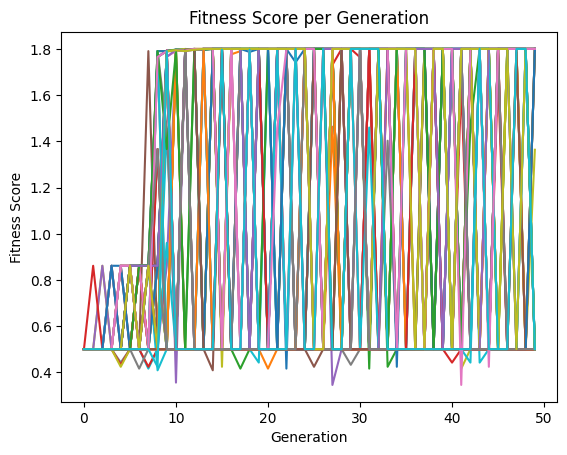

som_d_threshold : 0.007010754604790339

SOM Avg per sample : 0.020527571774600597 ms
SOM time: 0.01826953887939453 seconds

RF Avg per sample : 6.029494692770283 ms
RF time: 5.366250276565552 seconds

rf_total 2.6651082038879395
Combined Avg per sample : 3.015519795792826 ms
Combined time: 2.6838126182556152 seconds

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

 For SOM Model
--------------------------------------------------------------------------------

               precision    recall  f1-score   support

           0       0.94      0.93      0.94       470
           1       0.92      0.94      0.93       420

    accuracy                           0.93       890
   macro avg       0.93      0.93      0.93

100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


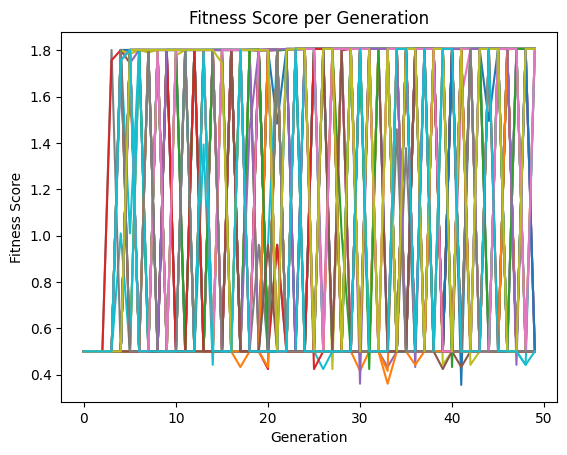

som_d_threshold : 0.005739727593789745

SOM Avg per sample : 0.020212805672977747 ms
SOM time: 0.017989397048950195 seconds

RF Avg per sample : 5.936115511347739 ms
RF time: 5.283142805099487 seconds

rf_total 2.6594698429107666
Combined Avg per sample : 3.005707665775599 ms
Combined time: 2.675079822540283 seconds

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

 For SOM Model
--------------------------------------------------------------------------------

               precision    recall  f1-score   support

           0       0.95      0.92      0.94       470
           1       0.92      0.95      0.93       420

    accuracy                           0.93       890
   macro avg       0.93      0.94      0.93

100%|██████████| 50/50 [02:17<00:00,  2.74s/it]


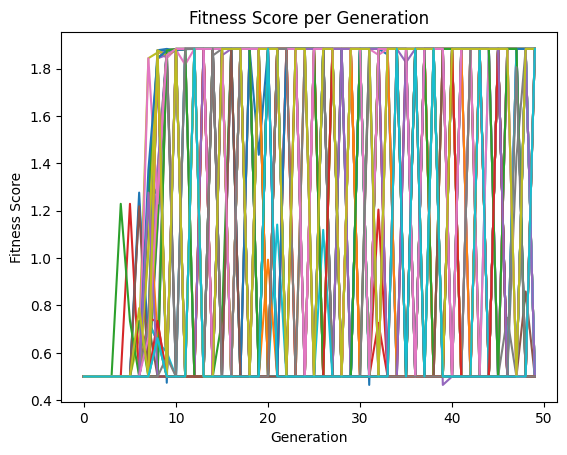

som_d_threshold : 0.005182562815730184

SOM Avg per sample : 0.011044501734591657 ms
SOM time: 0.04022407531738281 seconds

RF Avg per sample : 5.741132019248263 ms
RF time: 20.909202814102173 seconds

rf_total 12.219406843185425
Combined Avg per sample : 3.3812638104191066 ms
Combined time: 12.314562797546387 seconds

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

 For SOM Model
--------------------------------------------------------------------------------

               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1495
           1       0.97      0.96      0.97      2147

    accuracy                           0.96      3642
   macro avg       0.96      0.96      0.

100%|██████████| 50/50 [02:18<00:00,  2.77s/it]


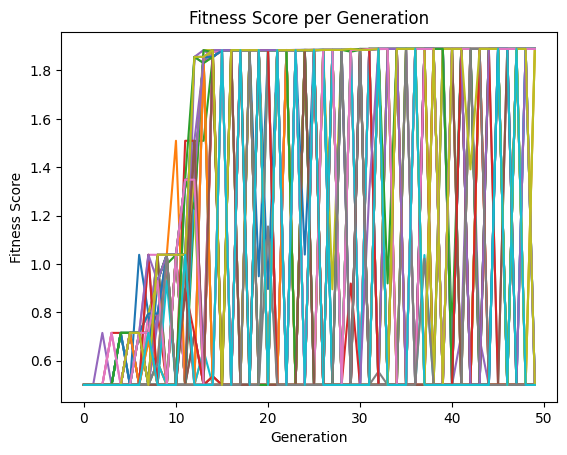

som_d_threshold : 0.006289480875135589

SOM Avg per sample : 0.010999200895289548 ms
SOM time: 0.04005908966064453 seconds

RF Avg per sample : 6.097486620090742 ms
RF time: 22.207046270370483 seconds

rf_total 12.032713413238525
Combined Avg per sample : 3.321036671885156 ms
Combined time: 12.095215559005737 seconds

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

 For SOM Model
--------------------------------------------------------------------------------

               precision    recall  f1-score   support

           0       0.93      0.98      0.96      1495
           1       0.99      0.95      0.97      2147

    accuracy                           0.96      3642
   macro avg       0.96      0.97      0.9

100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


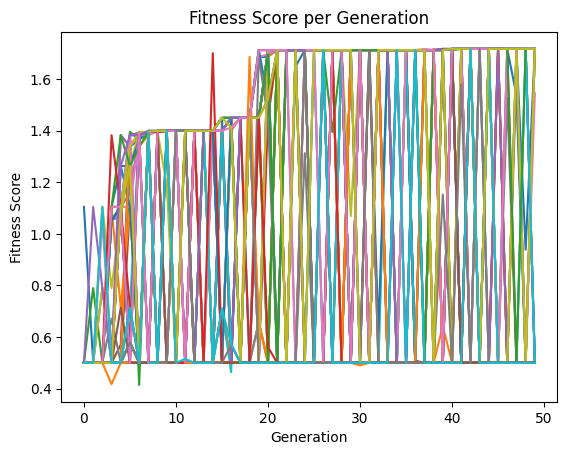

som_d_threshold : 0.004054681100684127

SOM Avg per sample : 0.020930490556378856 ms
SOM time: 0.03826093673706055 seconds

RF Avg per sample : 5.649912018222935 ms
RF time: 10.328039169311523 seconds

rf_total 7.299378156661987
Combined Avg per sample : 4.011438894584873 ms
Combined time: 7.3329102993011475 seconds

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

 For SOM Model
--------------------------------------------------------------------------------

               precision    recall  f1-score   support

           0       0.84      0.91      0.87       600
           1       0.95      0.92      0.93      1228

    accuracy                           0.91      1828
   macro avg       0.90      0.91      0.90

100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


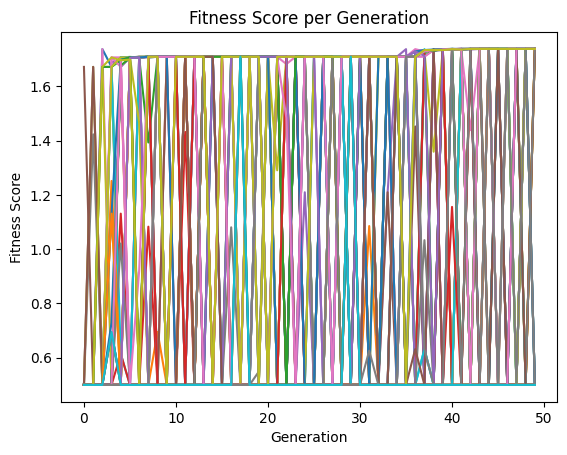

som_d_threshold : 0.004927668881269758

SOM Avg per sample : 0.020636771387813908 ms
SOM time: 0.03772401809692383 seconds

RF Avg per sample : 5.636123781392037 ms
RF time: 10.302834272384644 seconds

rf_total 7.10882830619812
Combined Avg per sample : 3.9084748053185527 ms
Combined time: 7.1446919441223145 seconds

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

 For SOM Model
--------------------------------------------------------------------------------

               precision    recall  f1-score   support

           0       0.82      0.94      0.88       600
           1       0.97      0.90      0.93      1228

    accuracy                           0.91      1828
   macro avg       0.90      0.92      0.91

In [49]:


# #self made data
# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/som_data.csv")
# comments.append("self made data")





results = []
iteration = 0
for url in urls:
  comment = comments[iteration]
  if 'without bandwidth' in comment:
    bandflag = 1
  else:
    bandflag = 0
  print(f"Iteration : {iteration}")

  df = pd.read_csv(url)
  if iteration >= len(results):
        results.append([])
  # y_pred_som_and_rf = with_som_and_rf(df,comment, bandflag) # without rf modify
  # value = som_with_som_and_rf_actual(df,comment, bandflag) # with rfmodify and working
  # value = som_with_varying_sigma_and_d_threshold(df) # finding value for sigma and d_threshold
  # value = som_with_varying_sigma_and_d_threshold_for_method_testing(df) # testing for sigma and d_value on modified
  # value = som_with_som_and_rf_actual_modified_som(df,comment, bandflag) # testing for all datasets with modified som
  value = config_call(df,comment, bandflag) # testing for all datasets with modified som and rf

  results[iteration].append(value)
  iteration = iteration + 1


In [50]:

results

[[{'tanh convo gaussian mean cosine': {'som_values': [{'evaluation1': {'com': ['self made data'],
       'accuracy': [93.37078651685393],
       'fdr': [7.728337236533955],
       'attack_as_normal': [26],
       'normal_as_attack': [33],
       'attack_as_attack': [394],
       'normal_as_normal': [437]},
      'som_time': 0.01826953887939453,
      'avg_time': 0.020527571774600597}],
    'rf_values': [{'evaluation1': {'com': ['self made data'],
       'accuracy': [99.8876404494382],
       'fdr': [0.0],
       'attack_as_normal': [1],
       'normal_as_attack': [0],
       'attack_as_attack': [419],
       'normal_as_normal': [470]},
      'rf_time': 5.366250276565552,
      'avg_time': 6.029494692770283}],
    'combined_values': [{'evaluation1': {'com': ['self made data'],
       'accuracy': [97.07865168539325],
       'fdr': [0.0],
       'attack_as_normal': [26],
       'normal_as_attack': [0],
       'attack_as_attack': [394],
       'normal_as_normal': [470]},
      'combined_ti

In [ ]:
# #save results to self_data_only.pkl
# with open('all_data_trial.pkl', 'wb') as f:
#     pickle.dump(results, f)

# read file all_data_trial.pkl as results
with open('all_data_trial.pkl', 'rb') as f:
    results = pickle.load(f)

In [ ]:
results

[[{'norm mean euclidean': {'som_values': [{'evaluation1': {'com': ['self made data'],
       'accuracy': [64.49438202247191],
       'fdr': [11.764705882352944],
       'attack_as_normal': [300],
       'normal_as_attack': [16],
       'attack_as_attack': [120],
       'normal_as_normal': [454]},
      'som_time': 0.012663602828979492,
      'avg_time': 0.014228767223572462}],
    'rf_values': [{'evaluation1': {'com': ['self made data'],
       'accuracy': [100.0],
       'fdr': [0.0],
       'attack_as_normal': [0],
       'normal_as_attack': [0],
       'attack_as_attack': [420],
       'normal_as_normal': [470]},
      'rf_time': 4.7169671058654785,
      'avg_time': 5.29996304029829}],
    'combined_values': [{'evaluation1': {'com': ['self made data'],
       'accuracy': [66.29213483146067],
       'fdr': [0.0],
       'attack_as_normal': [300],
       'normal_as_attack': [0],
       'attack_as_attack': [120],
       'normal_as_normal': [470]},
      'combined_time': 0.709485530853

In [51]:
value1 = results[0][0]
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[0][0][value]])
  value1 = results[0][0]
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[1][0][value]])
  value1 = results[0][0]
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[2][0][value]])

variation : [[tanh convo gaussian mean cosine]]
['self made data'] with [0.007010754604790339]
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| Method   |   Accuracy (%) |   FDR (%) |   Attack as Normal |   Normal as Attack |   Attack as Attack |   Normal as Normal |   Execution Time (s) |   Average Time (ms) |
+==========+================+===========+====================+====================+====================+====================+======================+=====================+
| SOM      |        93.3708 |   7.72834 |                 26 |                 33 |                394 |                437 |            0.0182695 |           0.0205276 |
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| RF       |        99.8876 |   0       |         

In [47]:
value1 = results[0][0]
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[0][0][value]])
  value1 = results[0][0]
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[1][0][value]])
  value1 = results[0][0]
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[2][0][value]])

variation : [[tanh convo gaussian mean cosine]]
['self made data'] with [0.005386447665433697]
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| Method   |   Accuracy (%) |   FDR (%) |   Attack as Normal |   Normal as Attack |   Attack as Attack |   Normal as Normal |   Execution Time (s) |   Average Time (ms) |
+==========+================+===========+====================+====================+====================+====================+======================+=====================+
| SOM      |        93.2584 |   9.09091 |                 20 |                 40 |                400 |                430 |            0.0121098 |           0.0136065 |
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| RF       |        99.8876 |   0       |         

In [ ]:
value1 = results[0][0]
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[0][0][value]])
  value1 = results[0][0]
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[1][0][value]])
  value1 = results[0][0]
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[2][0][value]])

variation : [[tanh convo gaussian mean cosine]]
['self made data'] with [0.005482831809782804]
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| Method   |   Accuracy (%) |   FDR (%) |   Attack as Normal |   Normal as Attack |   Attack as Attack |   Normal as Normal |   Execution Time (s) |   Average Time (ms) |
+==========+================+===========+====================+====================+====================+====================+======================+=====================+
| SOM      |        93.3708 |   8.69565 |                 21 |                 38 |                399 |                432 |           0.00977802 |           0.0109865 |
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| RF       |        99.8876 |   0       |         

## All with distance

In [ ]:
value1 = results[0][0]
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[0][0][value]])

variation : [[norm mean euclidean]]
['self made data'] with [0.08043873807603849]
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| Method   |   Accuracy (%) |   FDR (%) |   Attack as Normal |   Normal as Attack |   Attack as Attack |   Normal as Normal |   Execution Time (s) |   Average Time (ms) |
+==========+================+===========+====================+====================+====================+====================+======================+=====================+
| SOM      |        64.4944 |   11.7647 |                300 |                 16 |                120 |                454 |            0.0126636 |           0.0142288 |
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| RF       |       100      |    0      |                  0 | 

In [ ]:
value1 = results[0][0]
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[1][0][value]])

variation : [[norm mean euclidean]]
['1s split with '] with [0.005751751531754937]
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| Method   |   Accuracy (%) |   FDR (%) |   Attack as Normal |   Normal as Attack |   Attack as Attack |   Normal as Normal |   Execution Time (s) |   Average Time (ms) |
+==========+================+===========+====================+====================+====================+====================+======================+=====================+
| SOM      |        99.8902 |   0.18596 |                  0 |                  4 |               2147 |               1491 |            0.0224721 |          0.00617028 |
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| RF       |       100      |   0       |                  0 |

In [ ]:
value1 = results[0][0]
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[2][0][value]])

variation : [[norm mean euclidean]]
['filled 2s split with bandwidth caida 2007'] with [0.0007324236275574797]
+----------+----------------+------------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| Method   |   Accuracy (%) |    FDR (%) |   Attack as Normal |   Normal as Attack |   Attack as Attack |   Normal as Normal |   Execution Time (s) |   Average Time (ms) |
+==========+================+============+====================+====================+====================+====================+======================+=====================+
| SOM      |        68.1072 | 32.1527    |                  2 |                581 |               1226 |                 19 |            0.0113685 |           0.0062191 |
+----------+----------------+------------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| RF       |        99.3982 |

In [ ]:
# value1 = results[0][0]
# for value in value1:
#   print(f"variation : [[{value}]]")
#   show_as_table([results[3][0][value]])

## tanh convo maxpool gaussian mean varying difference


In [ ]:
value1 = results[0][0]
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[0][0][value]])

variation : [[tanh mean euclidean]]
['self made data'] with [0.1234315775621764]
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| Method   |   Accuracy (%) |   FDR (%) |   Attack as Normal |   Normal as Attack |   Attack as Attack |   Normal as Normal |   Execution Time (s) |   Average Time (ms) |
+==========+================+===========+====================+====================+====================+====================+======================+=====================+
| SOM      |        92.2472 |   10.5618 |                 22 |                 47 |                398 |                423 |           0.00354052 |          0.00397811 |
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| RF       |        99.8876 |    0      |                  1 |  

In [ ]:
value1 = results[0][0]
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[1][0][value]])

variation : [[tanh mean euclidean]]
['1s split with '] with [0.1643966881701886]
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| Method   |   Accuracy (%) |   FDR (%) |   Attack as Normal |   Normal as Attack |   Attack as Attack |   Normal as Normal |   Execution Time (s) |   Average Time (ms) |
+==========+================+===========+====================+====================+====================+====================+======================+=====================+
| SOM      |        67.71   |   6.99734 |               1097 |                 79 |               1050 |               1416 |             0.014895 |          0.00408978 |
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| RF       |       100      |   0       |                  0 |  

In [ ]:
value1 = results[0][0]
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[2][0][value]])

variation : [[tanh mean euclidean]]
['filled 2s split with bandwidth caida 2007'] with [0.142091088628623]
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| Method   |   Accuracy (%) |   FDR (%) |   Attack as Normal |   Normal as Attack |   Attack as Attack |   Normal as Normal |   Execution Time (s) |   Average Time (ms) |
+==========+================+===========+====================+====================+====================+====================+======================+=====================+
| SOM      |        90.5908 |   6.07321 |                 99 |                 73 |               1129 |                527 |            0.0134814 |          0.00737493 |
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| RF       |        99.5077 |   0     

## tanh convo maxpool gaussian median

In [ ]:
value1 = results[0][0]
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[0][0][value]])

variation : [[tanh mean euclidean]]
['self made data'] with [0.1234315775621764]
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| Method   |   Accuracy (%) |   FDR (%) |   Attack as Normal |   Normal as Attack |   Attack as Attack |   Normal as Normal |   Execution Time (s) |   Average Time (ms) |
+==========+================+===========+====================+====================+====================+====================+======================+=====================+
| SOM      |        92.2472 |   10.5618 |                 22 |                 47 |                398 |                423 |           0.00354052 |          0.00397811 |
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| RF       |        99.8876 |    0      |                  1 |  

In [ ]:
value1 = results[0][0]
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[1][0][value]])

variation : [[tanh mean euclidean]]
['1s split with '] with [0.1643966881701886]
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| Method   |   Accuracy (%) |   FDR (%) |   Attack as Normal |   Normal as Attack |   Attack as Attack |   Normal as Normal |   Execution Time (s) |   Average Time (ms) |
+==========+================+===========+====================+====================+====================+====================+======================+=====================+
| SOM      |        67.71   |   6.99734 |               1097 |                 79 |               1050 |               1416 |             0.014895 |          0.00408978 |
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| RF       |       100      |   0       |                  0 |  

In [ ]:
value1 = results[0][0]
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[2][0][value]])

variation : [[tanh mean euclidean]]
['filled 2s split with bandwidth caida 2007'] with [0.142091088628623]
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| Method   |   Accuracy (%) |   FDR (%) |   Attack as Normal |   Normal as Attack |   Attack as Attack |   Normal as Normal |   Execution Time (s) |   Average Time (ms) |
+==========+================+===========+====================+====================+====================+====================+======================+=====================+
| SOM      |        90.5908 |   6.07321 |                 99 |                 73 |               1129 |                527 |            0.0134814 |          0.00737493 |
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| RF       |        99.5077 |   0     

In [ ]:
value1 = results[0][0]
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[0][0][value]])






variation : [[tanh mean euclidean]]
['self made data'] with [0.1234315775621764]
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| Method   |   Accuracy (%) |   FDR (%) |   Attack as Normal |   Normal as Attack |   Attack as Attack |   Normal as Normal |   Execution Time (s) |   Average Time (ms) |
+==========+================+===========+====================+====================+====================+====================+======================+=====================+
| SOM      |        92.2472 |   10.5618 |                 22 |                 47 |                398 |                423 |           0.00354052 |          0.00397811 |
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| RF       |        99.8876 |    0      |                  1 |  

In [ ]:
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[1][0][value]])



variation : [[tanh mean euclidean]]
['1s split with '] with [0.1643966881701886]
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| Method   |   Accuracy (%) |   FDR (%) |   Attack as Normal |   Normal as Attack |   Attack as Attack |   Normal as Normal |   Execution Time (s) |   Average Time (ms) |
+==========+================+===========+====================+====================+====================+====================+======================+=====================+
| SOM      |        67.71   |   6.99734 |               1097 |                 79 |               1050 |               1416 |             0.014895 |          0.00408978 |
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| RF       |       100      |   0       |                  0 |  

In [ ]:
for value in value1:
  print(f"variation : [[{value}]]")
  show_as_table([results[2][0][value]])

variation : [[tanh mean euclidean]]
['filled 2s split with bandwidth caida 2007'] with [0.142091088628623]
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| Method   |   Accuracy (%) |   FDR (%) |   Attack as Normal |   Normal as Attack |   Attack as Attack |   Normal as Normal |   Execution Time (s) |   Average Time (ms) |
+==========+================+===========+====================+====================+====================+====================+======================+=====================+
| SOM      |        90.5908 |   6.07321 |                 99 |                 73 |               1129 |                527 |            0.0134814 |          0.00737493 |
+----------+----------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| RF       |        99.5077 |   0     

In [ ]:
show_as_table([value1])

KeyError: 'som_values'

In [ ]:
# #save results to self_data_only.pkl
# with open('self_data_only.pkl', 'wb') as f:
#     pickle.dump(results, f)


## tables


In [ ]:
# final_result = {}

In [ ]:
final_result

In [ ]:
for data in results: # with median 50X50 50 gen tanh normalize convolution laplacian
  show_as_table(data)
final_result['with median 50X50 50 gen tanh normalize convolution laplacian'] = data

In [ ]:
# for data in results: # with median 50X50 50 gen tanh normalize
#   show_as_table(data)
# final_result['with median 50X50 50 gen tanh normalize'] = data

In [ ]:
for data in results: # with mean 50X50 50 gen tanh normalize
  show_as_table(data)

In [ ]:
for data in results: # with mean 30X30 10 gen tanh normalize
  show_as_table(data)

In [ ]:
for data in results: # with mean 30X30 50 gen tanh normalize
  show_as_table(data)

In [ ]:
for data in results: # with mean 10X10 50 gen tanh normalize
  show_as_table(data)

In [ ]:
for data in results: # with mean 100X100 50 gen tanh normalize
  show_as_table(data)

In [ ]:
for data in results: # with mean 100X100 500 gen custom normalize
  show_as_table(data)

In [ ]:
for data in results: # with mean 100 X 100 500 gen customdef normalize convo laplacian
  show_as_table(data)

In [ ]:
for data in results: # with mean 100 X 100 50 gen
  show_as_table(data)

In [ ]:
for data in results: # with mean 100 X 100 500 gen
  show_as_table(data)

In [ ]:
for data in results: # with mean 100 X 100
  show_as_table(data)

In [ ]:
for data in results: # with mean 50 X 50
  show_as_table(data)

In [ ]:
for data in results: # with mean convo laplacian avgpooled
  show_as_table(data)

In [ ]:
for data in results: # with mean convo laplacian maxpooled
  show_as_table(data)

In [ ]:
for data in results: # with mean convo laplacian
  show_as_table(data)

In [ ]:
for data in results: # with median convo laplacian
  show_as_table(data)

In [ ]:
for data in results: # with median convo gaussian
  show_as_table(data)

In [ ]:
for data in results: # with mean convo gaussian
  show_as_table(data)

In [ ]:
result_df = pd.DataFrame(results[0][0]["som_values"][0])
result_df

In [ ]:
df_test = pd.DataFrame(results[0]['som_values'][0][0])
df_test

In [ ]:
# var_1_with_mean_convolution_and_gaussian = results

In [ ]:
results_df = pd.DataFrame(results)
results_df

## other


In [ ]:
# make each row of result_df into separate dfs
for i in range(len(results)):
    results[i] = pd.DataFrame(results[i])
    results[i].columns = ['som_values', 'rf_values', 'y_pred_som_and_rf_values']
    # results[i] = results[i].astype(float)
    # print(results[i])
results[0]

In [ ]:
# each column of results[0] into a dataframe
df1 = results[0]['som_values']
df2 = results[0]['rf_values']
df3 = results[0]['y_pred_som_and_rf_values']

In [ ]:
df1[0][0]

In [ ]:
value_pd1 = (df1[0][0])
data_dicts = value_pd1
rows = []

# Iterate over each dictionary and convert to DataFrame row
for data_dict in data_dicts:
    rows.append(pd.DataFrame(data_dict, index=[0]))

# Concatenate all rows into a single DataFrame
df = pd.concat(rows, ignore_index=True)

df

In [ ]:
df

In [ ]:
## printing all the max accuracy rows
value_pd[value_pd['accuracy'] == value_pd['accuracy'].max()]

In [ ]:
get_d_threshold_value_for_max_eval(value_pd)

In [ ]:
## printing all the max accuracy rows
value_pd[value_pd['accuracy'] == value_pd['accuracy'].max()]

In [ ]:


# # #self made data
# # urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/som_data.csv")
# # comments.append("self made data")





# results = []
# iteration = 0
# for url in urls:
#   comment = comments[iteration]
#   if 'without bandwidth' in comment:
#     bandflag = 1
#   else:
#     bandflag = 0
#   print(f"Iteration : {iteration}")

#   df = pd.read_csv(url)

#   # y_pred_som_and_rf = with_som_and_rf(df,comment, bandflag) # without rf modify
#   value = som_with_som_and_rf_actual(df,comment, bandflag) # with rfmodify and working
#   # value = som_with_varying_sigma_and_d_threshold(df)

#   results.append(value)
#   iteration = iteration + 1


In [ ]:
# y_pred_som_and_rf
value_1 = pd.DataFrame(value_pd[0])
value_1

In [ ]:
# results

In [ ]:
# resultant_columns = ['som_values', 'rf_values', 'y_pred_som_and_rf_values']
# resultant_df = pd.DataFrame(results,columns=resultant_columns)

In [ ]:
# resultant_df_som = resultant_df['som_values']
# resultant_df_rf = resultant_df['rf_values']
# resultant_df_som_and_rf = resultant_df['y_pred_som_and_rf_values']

In [ ]:
# resultant_df_som

In [ ]:
# resultant_df_rf

In [ ]:
# resultant_columns = ['com','accuracy', 'attack_as_normal', 'normal_as_attack', 'attack_as_attack', 'normal_as_normal']
# resultant_df_som = pd.DataFrame(resultant_df_som,columns=resultant_columns)

In [ ]:


# # #self made data
# # urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/som_data.csv")
# # comments.append("self made data")





# results = []
# iteration = 0
# for url in urls:
#   comment = comments[iteration]
#   if 'without bandwidth' in comment:
#     bandflag = 1
#   else:
#     bandflag = 0
#   print(f"Iteration : {iteration}")

#   df = pd.read_csv(url)

#   # y_pred_som_and_rf = with_som_and_rf(df,comment, bandflag) # without rf modify
#   value = som_with_som_and_rf_actual(df,comment, bandflag) # with rfmodify and working
#   # value = som_with_varying_sigma_and_d_threshold(df)

#   results.append(value)
#   iteration = iteration + 1


In [ ]:
# resultant_df_som

In [ ]:
# y_pred_som_and_rf

In [ ]:
# result